In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def augmentation():
    count_image = 250
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    # selected_files_for_horizontal = []
    count_image = 1
    selected_files_for_horizontal = random.sample(image_files, count_image)

    for filename in selected_files_for_horizontal:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [3]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [4]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [7]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [5]:
def draw(orig_image, orig_masks, mask_image, intersec_mask):
    fig, axes = plt.subplots(1, 4)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    axes[3].imshow(intersec_mask)
    axes[3].set_title('Difference Mask')

    plt.tight_layout()
    plt.show()

In [3]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [4]:
def ap_k(predictions, targets, k, klass):
    precision = 0
    tp = 0
    all_det = 0
    for i in range(k):
        predict = predictions[i]
        target = targets[i]

        if klass:
            tp += np.sum(predict[predict == target])
            all_det += np.sum(predict)
            precision += tp / all_det
        else:
            tp += len(predict[predict == target]) - np.count_nonzero(predict[predict == target])
            all_det += predict.size - np.count_nonzero(predict)
            precision += tp / all_det
    return precision / k 

def compute_ap(predictions, targets, k):
    return (ap_k(predictions, targets, k, True) + ap_k(predictions, targets, k, False)) / 2, ap_k(predictions, targets, k, True)



### Preprocessing (подготовка данных)

In [8]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')

        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [9]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 8

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [9]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion, model_name, scheduler=None):
  train_losses = []
  val_losses = []
  iou_test = []
  max_iou = 0.0

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))
    
    if scheduler is not None:
      scheduler.step(loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    if iou > max_iou:
       max_iou = iou
       torch.save(model.state_dict(), f"models/{model_name}_IOU-{iou}.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [43]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            new_outputs = torch.zeros(outputs.shape[0], outputs.shape[1], outputs.shape[2], outputs.shape[3])
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1

            # for i in range(outputs.shape[0]):
            #     for j in range(outputs.shape[2]):
            #         for k in range(outputs.shape[3]):
            #             if outputs[i, 0, j, k] == 1:
            #                 for m in range(-1, 2):
            #                     for n in range(-1, 2):
            #                         if 0 <= j + m < outputs.shape[2] - 4 and 0 <= k + n < outputs.shape[3] - 4:
            #                             new_outputs[i, 0, j + 1 + m, k + 1 + n] = 1

            # outputs = new_outputs

            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())

            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [6]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    apk, ap = compute_ap(predictions, orig_masks, len(predictions))

    print(f"IOU: {iou}")
    print(f"AP for Two Classes: {apk}")
    print(f"AP for Mouse Class: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i], intersection_masks[i])


### Experiments

In [12]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [16]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [17]:
import torch.nn.functional as F


class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)
        

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        x = F.softmax(x, dim=1)

        return x


In [18]:
#model = UNET(in_chnls = 3, n_classes = 1).to(device)

In [19]:
# model = SegNet(in_chn = 3, out_chn=1).to(device)

In [11]:
import segmentation_models_pytorch as smp
model_name = 'mobileone_s4'
model = smp.Unet(model_name, classes=1)
#model = smp.Unet('resnet50', classes=1)
model.to(device)

Unet(
  (encoder): MobileOne(
    (stage0): MobileOneBlock(
      (se): Identity()
      (activation): ReLU()
      (rbr_conv): ModuleList(
        (0): Sequential(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (rbr_scale): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stage1): Sequential(
      (0): MobileOneBlock(
        (se): Identity()
        (activation): ReLU()
        (rbr_conv): ModuleList(
          (0): Sequential(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (rbr_sc

In [26]:
import segmentation_models_pytorch as smp

learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
# criterion = nn.BCEWithLogitsLoss()
#criterion = smp.losses.JaccardLoss(mode='binary')
criterion = smp.losses.DiceLoss(mode='binary')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [27]:
num_epochs = 20
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion, model_name, scheduler)

100%|██████████| 7/7 [00:00<00:00,  9.92it/s]


Epoch [1/20], Train loss: 58.7618, Val loss: 1.9619, IOU: 0.8190


100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


Epoch [2/20], Train loss: 11.9268, Val loss: 1.2710, IOU: 0.8210


100%|██████████| 7/7 [00:00<00:00, 10.17it/s]


Epoch [3/20], Train loss: 9.1608, Val loss: 1.1397, IOU: 0.8472


100%|██████████| 7/7 [00:00<00:00, 10.89it/s]


Epoch [4/20], Train loss: 8.1273, Val loss: 1.0698, IOU: 0.8447


100%|██████████| 7/7 [00:00<00:00, 10.26it/s]


Epoch [5/20], Train loss: 7.5713, Val loss: 1.0642, IOU: 0.8422


100%|██████████| 7/7 [00:00<00:00,  9.90it/s]


Epoch [6/20], Train loss: 7.0428, Val loss: 1.0952, IOU: 0.8622


100%|██████████| 7/7 [00:00<00:00, 10.12it/s]


Epoch [7/20], Train loss: 6.6772, Val loss: 1.0163, IOU: 0.8313


100%|██████████| 7/7 [00:00<00:00, 10.32it/s]


Epoch [8/20], Train loss: 6.4481, Val loss: 0.9977, IOU: 0.8383


100%|██████████| 7/7 [00:00<00:00, 10.05it/s]


Epoch [9/20], Train loss: 6.1134, Val loss: 0.9981, IOU: 0.8407


100%|██████████| 7/7 [00:00<00:00, 10.04it/s]


Epoch [10/20], Train loss: 5.9590, Val loss: 1.0048, IOU: 0.8298


100%|██████████| 7/7 [00:00<00:00, 10.23it/s]


Epoch [11/20], Train loss: 5.8301, Val loss: 0.9706, IOU: 0.8515


100%|██████████| 7/7 [00:00<00:00,  9.99it/s]


Epoch [12/20], Train loss: 5.6769, Val loss: 0.9816, IOU: 0.8488


100%|██████████| 7/7 [00:00<00:00,  9.44it/s]


Epoch [13/20], Train loss: 5.6011, Val loss: 0.9902, IOU: 0.8469


100%|██████████| 7/7 [00:00<00:00, 10.04it/s]


Epoch [14/20], Train loss: 5.4289, Val loss: 0.9657, IOU: 0.8389


100%|██████████| 7/7 [00:00<00:00, 10.36it/s]


Epoch [15/20], Train loss: 5.3271, Val loss: 0.9656, IOU: 0.8390


100%|██████████| 7/7 [00:00<00:00, 10.31it/s]


Epoch [16/20], Train loss: 5.2510, Val loss: 0.9920, IOU: 0.8519


100%|██████████| 7/7 [00:00<00:00, 10.02it/s]


Epoch [17/20], Train loss: 5.1110, Val loss: 0.9711, IOU: 0.8322


100%|██████████| 7/7 [00:00<00:00, 10.25it/s]


Epoch [18/20], Train loss: 5.0207, Val loss: 0.9534, IOU: 0.8349


100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


Epoch [19/20], Train loss: 4.9430, Val loss: 0.9535, IOU: 0.8370


100%|██████████| 7/7 [00:00<00:00, 10.03it/s]

Epoch [20/20], Train loss: 4.8644, Val loss: 0.9564, IOU: 0.8297


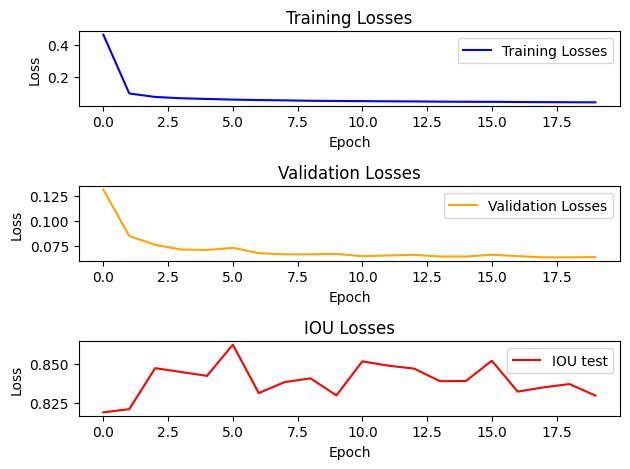

In [28]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [12]:
model.load_state_dict(torch.load("models\mobileone_s4_IOU-0.8621597802076076.pth"))

<All keys matched successfully>

In [36]:
validation(model, train_loader, 1)

  0%|          | 0/127 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [37]:
validation(model, val_loader, 10)

  0%|          | 0/15 [00:12<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


IOU: 0.8621597802076076
AP for Two Classes: 0.9099180028300619
AP for Mouse Class: 0.8233470335806838


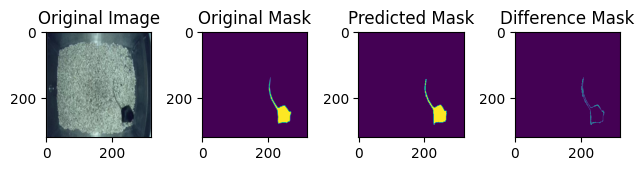

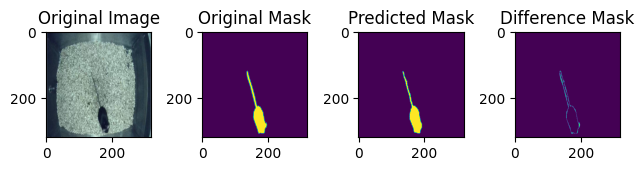

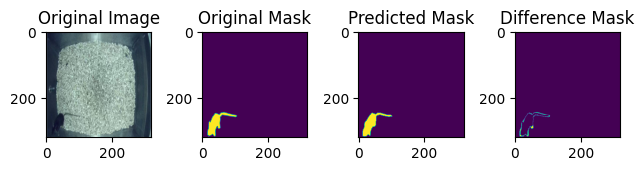

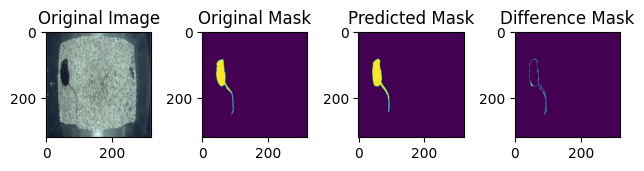

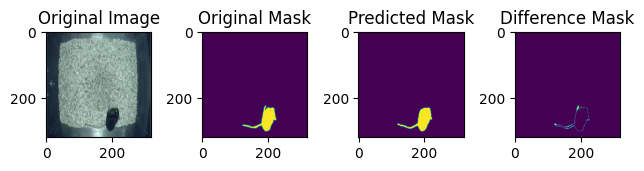

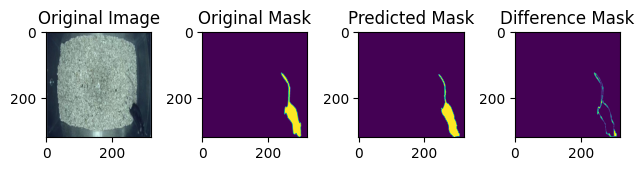

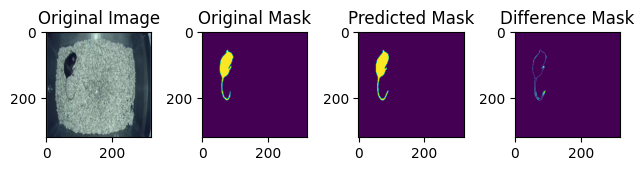

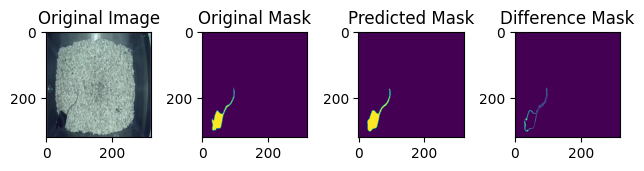

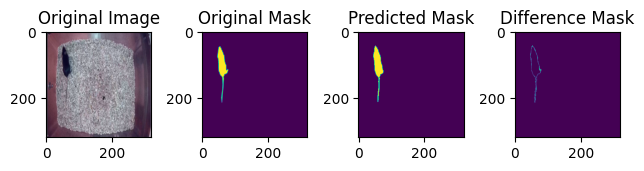

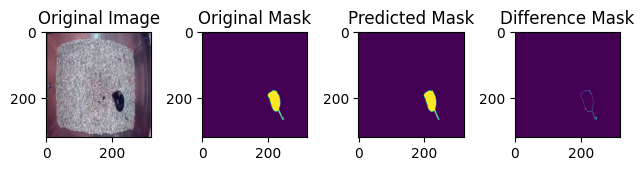

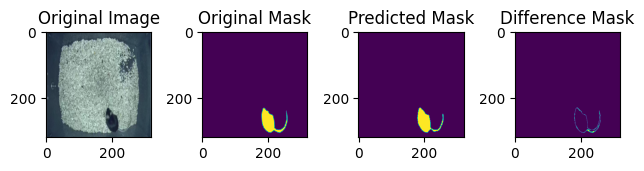

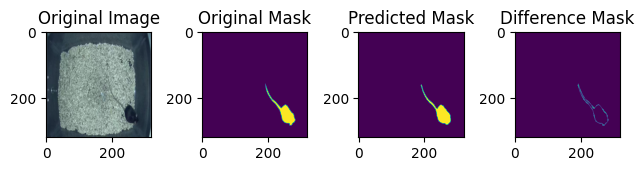

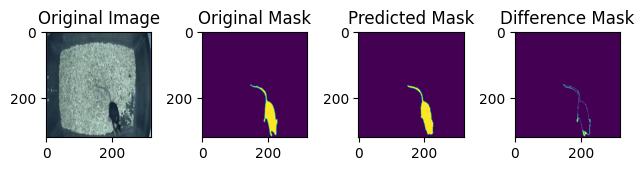

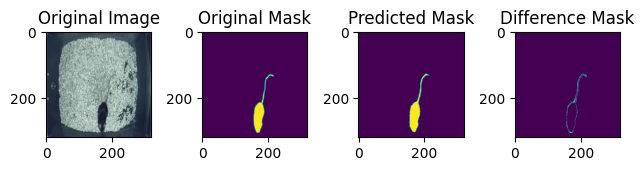

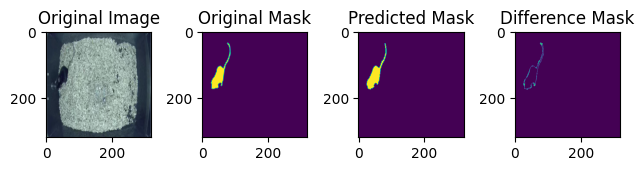

In [44]:
validation(model, test_loader, 15)

validation(model, test_loader, 10)

In [27]:
delete_generated_images(data_vertical, data_horizontal)

NameError: name 'data_vertical' is not defined